In [2]:
import time
import os
import datetime
import pandas as pd
import numpy as np
import collections
%matplotlib inline
import matplotlib.pyplot as plt
import math
import sys
from copy import copy
import random
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

#### Load and convert data

In [3]:
def convert_weekdays(data):
    data.rename(columns={"Weekday": "WeekdayStr"}, inplace=True)
    data["Weekday"] = 0
    data.loc[data.WeekdayStr == "Monday", "Weekday"] = 1
    data.loc[data.WeekdayStr == "Tuesday", "Weekday"] = 2
    data.loc[data.WeekdayStr == "Wednesday", "Weekday"] = 3
    data.loc[data.WeekdayStr == "Thursday", "Weekday"] = 4
    data.loc[data.WeekdayStr == "Friday", "Weekday"] = 5
    data.loc[data.WeekdayStr == "Saturday", "Weekday"] = 6
    data.loc[data.WeekdayStr == "Sunday", "Weekday"] = 7
    data.drop(["WeekdayStr"], axis=1, inplace=True)

def update_descriptions(data):
    for i, row in data.iterrows():
        data.set_value(i, "DepartmentDescription", row["DepartmentDescription"] + " (" + str(row["DepartmentId"]) + ")")
        data.set_value(i, "Upc", row["Upc"] + " (" + str(row["UpcId"]) + ")")
    
def convert_data(train, test):
    train_copy = train.copy()
    test_copy = test.copy()
    
    # convert weekdays to int value
    convert_weekdays(train_copy)
    convert_weekdays(test_copy)
    
    # create department ids
    le = LabelEncoder()
    le.fit(train_copy.DepartmentDescription)
    train_copy["DepartmentId"] = 0
    train_copy.DepartmentId = le.transform(train_copy.DepartmentDescription)
    test_copy["DepartmentId"] = 0
    test_copy.DepartmentId = le.transform(test_copy.DepartmentDescription)
    
    # create upc ids
    le = LabelEncoder()
    upc = np.concatenate((train_copy.Upc, test_copy.Upc), axis=1)
    le.fit(upc)
    train_copy["UpcId"] = 0
    train_copy.UpcId = le.transform(train_copy.Upc)
    test_copy["UpcId"] = 0
    test_copy.UpcId = le.transform(test_copy.Upc)
    
    # update descriptions (department, upc)
    update_descriptions(train_copy)
    update_descriptions(test_copy)
    
    return train_copy, test_copy

In [4]:
train = pd.read_csv("data/train.csv", dtype={"Upc": str})
train.DepartmentDescription = train.DepartmentDescription.astype(str)
train.Upc = train.Upc.astype(str)
train.TripType = train.TripType.astype(str)
test = pd.read_csv("data/test.csv", dtype={"Upc": str})
test.DepartmentDescription = test.DepartmentDescription.astype(str)
test.Upc = test.Upc.astype(str)
train, test = convert_data(train, test)

In [5]:
train.head(10)

,TripType,VisitNumber,Upc,ScanCount,DepartmentDescription,FinelineNumber,Weekday,DepartmentId,UpcId
0,999,5,68113152929 (57573),-1,FINANCIAL SERVICES (20),1000,5,20,57573
1,30,7,60538815980 (46822),1,SHOES (62),8931,5,62,46822
2,30,7,7410811099 (73752),1,PERSONAL CARE (50),4504,5,50,73752
3,26,8,2238403510 (10911),2,PAINT AND ACCESSORIES (49),3565,5,49,10911
4,26,8,2006613744 (8931),2,PAINT AND ACCESSORIES (49),1017,5,49,8931
5,26,8,2006618783 (8947),2,PAINT AND ACCESSORIES (49),1017,5,49,8947
6,26,8,2006613743 (8930),1,PAINT AND ACCESSORIES (49),1017,5,49,8930
7,26,8,7004802737 (59876),1,PAINT AND ACCESSORIES (49),2802,5,49,59876
8,26,8,2238495318 (10936),1,PAINT AND ACCESSORIES (49),4501,5,49,10936
9,26,8,2238400200 (10903),-1,PAINT AND ACCESSORIES (49),3565,5,49,10903


In [6]:
test.head(10)

,VisitNumber,Upc,ScanCount,DepartmentDescription,FinelineNumber,Weekday,DepartmentId,UpcId
0,1,72503389714 (69347),1,SHOES (62),3002,5,62,69347
1,1,1707710732 (7287),1,DAIRY (16),1526,5,16,7287
2,1,89470001026 (121863),1,DAIRY (16),1431,5,16,121863
3,1,88491211470 (111450),1,GROCERY DRY GOODS (24),3555,5,24,111450
4,2,2840015224 (16123),1,DSD GROCERY (17),4408,5,17,16123
5,2,7874205264 (87141),1,BAKERY (3),5019,5,3,87141
6,2,87458604271 (105787),1,IMPULSE MERCHANDISE (32),8023,5,32,105787
7,2,87458604214 (105776),1,IMPULSE MERCHANDISE (32),8023,5,32,105776
8,3,7410811099 (73752),1,PERSONAL CARE (50),4504,5,50,73752
9,3,7410811099 (73752),-1,PERSONAL CARE (50),4504,5,50,73752


In [7]:
class Visit:
    def __init__(self, number, weekday, trip_type):
        self.number = number
        self.weekday = weekday
        self.trip_type = trip_type
        self.products = {}
        
    def add_product(self, product_id, count):
        if product_id not in self.products:
            self.products[product_id] = 0
        self.products[product_id] += count
        if self.products[product_id] == 0:
            del self.products[product_id]
        
    def calculate_additional_data(self, products, departments):
        remove = set()
        for product_id in self.products:
            if self.products[product_id] <= 0:
                remove.add(product_id)
        for product_id in remove:
            del self.products[product_id]
        self.products_sum = 0
        self.departments = {}
        self.fineline_numbers = {}
        for product_id in self.products:
            product = products[product_id]
            n = self.products[product_id]
            self.products_sum += n
            if product.department_id not in self.departments:
                self.departments[product.department_id] = 0
            self.departments[product.department_id] += n
            if product.fineline_number not in self.fineline_numbers:
                self.fineline_numbers[product.fineline_number] = 0
            self.fineline_numbers[product.fineline_number] += n
                   
class Product:
    def __init__(self, id, fineline_number, department_id, upc):
        self.id = id
        self.fineline_number = fineline_number
        self.department_id = department_id
        self.upc = upc
        self.source = None # 0 - train, 1 - test, 2 - both
        
    def set_train_source(self):
        if self.source == 2:
            return
        if self.source == 1:
            self.source = 2
        else:
            self.source = 0
    
    def set_test_source(self):
        if self.source == 2:
            return
        if self.source == 0:
            self.source = 2
        else:
            self.source = 1 
        
class Department:
    def __init__(self, id, description):
        self.id = id
        self.description = description
        self.products = set()
        
    def add_product(self, product_id):
        if product_id in self.products:
            return
        self.products.add(product_id)
        
class FinelineNumber:
    def __init__(self, number):
        self.number = number
        self.products = set()
        
    def add_product(self, product_id):
        if product_id in self.products:
            return
        self.products.add(product_id)

In [8]:
def load_products(train, test):
    products = {}
    append_products(train, products, True)
    append_products(test, products, False)
    return products

def append_products(data, products, is_train):
    for i, row in data.iterrows():
        product_id = row["UpcId"]
        if product_id not in products:
            products[product_id] = Product(product_id, row["FinelineNumber"], row["DepartmentId"], row["Upc"])
        if is_train:
            products[product_id].set_train_source()
        else:
            products[product_id].set_test_source()

def load_departments(data):
    departments = {}
    for i, row in data.iterrows():
        department_id = row["DepartmentId"]
        if department_id not in departments:
            departments[department_id] = Department(department_id, row["DepartmentDescription"])
        departments[department_id].add_product(row["UpcId"])
    return departments

def load_fineline_numbers(data):
    fineline_numbers = {}
    for i, row in data.iterrows():
        fineline_number = row["FinelineNumber"]
        if math.isnan(fineline_number):
            continue
        fineline_number = int(fineline_number)
        if fineline_number not in fineline_numbers:
            fineline_numbers[fineline_number] = FinelineNumber(fineline_number)
        fineline_numbers[fineline_number].add_product(row["UpcId"])
    return fineline_numbers

def load_visits(data, products, departments):
    visits = {}
    for i, row in data.iterrows():
        number = row["VisitNumber"]
        if number not in visits:
            trip_type = None
            if "TripType" in row:
                trip_type = row["TripType"]
            visits[number] = Visit(number, row["Weekday"], trip_type)
        visits[number].add_product(row["UpcId"], row["ScanCount"])
    for visit in visits.values():
        visit.calculate_additional_data(products, departments)
    return visits

In [9]:
products = load_products(train, test)
departments = load_departments(train)
fineline_numbers = load_fineline_numbers(train)
visits_train = load_visits(train, products, departments)
visits_test = load_visits(test, products, departments)

In [10]:
class Metadata:
    def __init__(self, n_of_departments, n_of_finelines):
        self.n_of_departments = n_of_departments
        self.n_of_finelines = n_of_finelines
        
metadata = Metadata(len(departments), len(fineline_numbers))

In [11]:
n_hash = 500

def create_ml_dataset(visits, products, departments, fineline_numbers):
    global metadata
    global n_hash
    n = len(visits)
    df = pd.DataFrame(index=range(n))
    df["VisitNumber"] = visits.keys()
    df["Weekday"] = 0
    df["NumberOfProducts"] = 0
    df["NumberOfDepartments"] = 0
    df["NumberOfFinelines"] = 0
    df["ProductsSum"] = 0
    df["TripType"] = 0
    for department_id in departments:
        df["Department_" + str(department_id)] = 0
    #for number in fineline_numbers:
    #    df["FinelineNumber_" + str(number)] = 0
    for number in xrange(n_hash):
        df["FinelineNumber_" + str(number)] = 0
    #df = df.to_sparse(fill_value=0)
    for i, row in df.iterrows():
        visit_number = row["VisitNumber"]
        visit = visits[visit_number]
        df.set_value(i, "Weekday", visit.weekday)
        df.set_value(i, "NumberOfProducts", len(visit.products))
        df.set_value(i, "NumberOfDepartments", len(visit.departments))
        df.set_value(i, "NumberOfFinelineNumbers", len(visit.fineline_numbers))
        df.set_value(i, "ProductsSum", visit.products_sum)
        df.set_value(i, "TripType", visit.trip_type)
        for department_id in visit.departments:
            df.set_value(i, "Department_" + str(department_id), visit.departments[department_id])
        for number in visit.fineline_numbers:
            if math.isnan(number):
                continue
            df.set_value(i, "FinelineNumber_" + str(int(int(number)%n_hash)), 1)
            #df.set_value(i, "FinelineNumber_" + str(number), visit.fineline_numbers[number])
    df["NumberOfFinelineNumbers"] = df["NumberOfFinelineNumbers"].astype(int)
    return df

In [12]:
data_train = create_ml_dataset(visits_train, products, departments, fineline_numbers)
data_train.to_csv("data/data_train.csv", index=False)

In [13]:
data_test = create_ml_dataset(visits_test, products, departments, fineline_numbers)
data_test.to_csv("data/data_test.csv", index=False)

#### Exploratory analysis

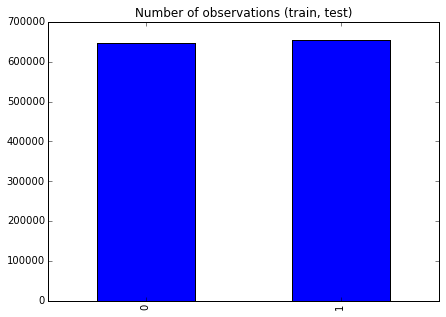

In [14]:
h = pd.Series([train.shape[0], test.shape[0]]).plot(kind = "bar", figsize=(7, 5), 
                                                    title="Number of observations (train, test)")

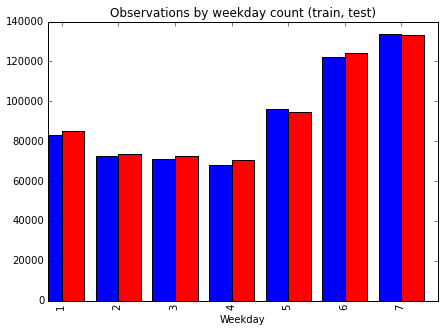

In [15]:
lst = train.groupby("Weekday")["Weekday"].count()
h = lst.plot(kind = "bar", figsize=(7, 5), title="Observations by weekday count (train, test)", 
             position=1, color="blue",width=0.4)
lst = test.groupby("Weekday")["Weekday"].count()
h = lst.plot(kind = "bar",color="red",position=0,width=0.4)

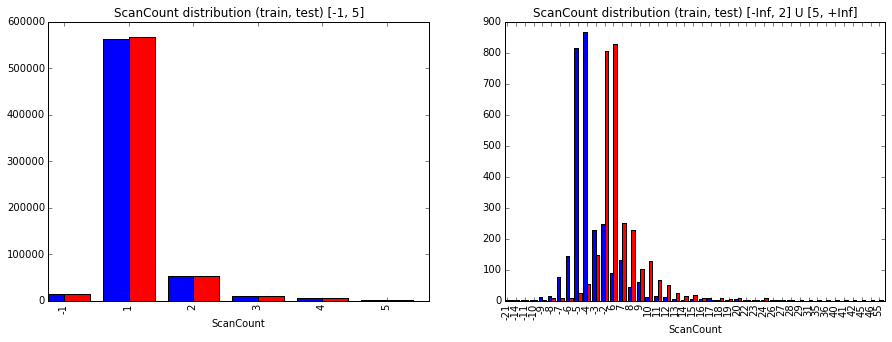

In [16]:
fig, axs = plt.subplots(1,2)
lst = train[(train.ScanCount > -2) & (train.ScanCount < 6)].groupby("ScanCount")["ScanCount"].count()
h = lst.plot(kind = "bar", figsize=(15, 5), ax=axs[0], position=1, color="blue", width=0.4,
             title="ScanCount distribution (train, test) [-1, 5]")
lst = test[(test.ScanCount > -2) & (test.ScanCount < 6)].groupby("ScanCount")["ScanCount"].count()
h = lst.plot(kind = "bar", color="red", ax=axs[0], position=0, width=0.4)
lst = train[(train.ScanCount <= -2) | (train.ScanCount >= 6)].groupby("ScanCount")["ScanCount"].count()
h = lst.plot(kind = "bar", figsize=(15, 5), ax=axs[1], position=1, color="blue", width=0.4,
             title="ScanCount distribution (train, test) [-Inf, 2] U [5, +Inf]")
lst = test[(test.ScanCount <= -2) | (test.ScanCount >= 6)].groupby("ScanCount")["ScanCount"].count()
h = lst.plot(kind = "bar", color="red", ax=axs[1], position=0, width=0.4)

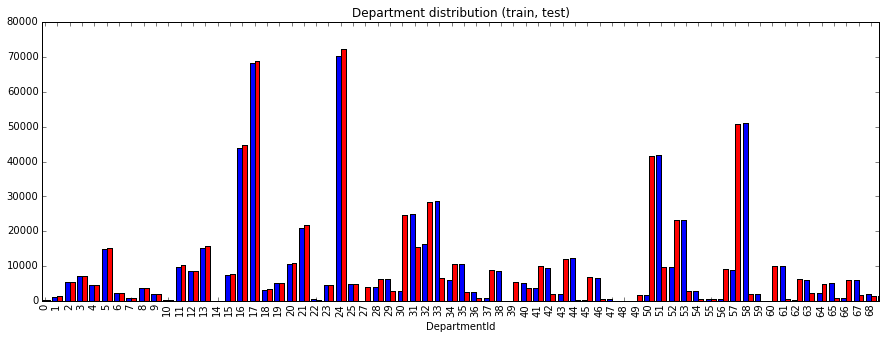

In [17]:
lst = train.groupby("DepartmentId")["DepartmentId"].count()
h = lst.plot(kind = "bar", figsize=(15, 5), title="Department distribution (train, test)", 
             position=1, color="blue", width=0.4)
lst = test.groupby("DepartmentId")["DepartmentId"].count()
h = lst.plot(kind = "bar", color="red", position=0, width=0.4)

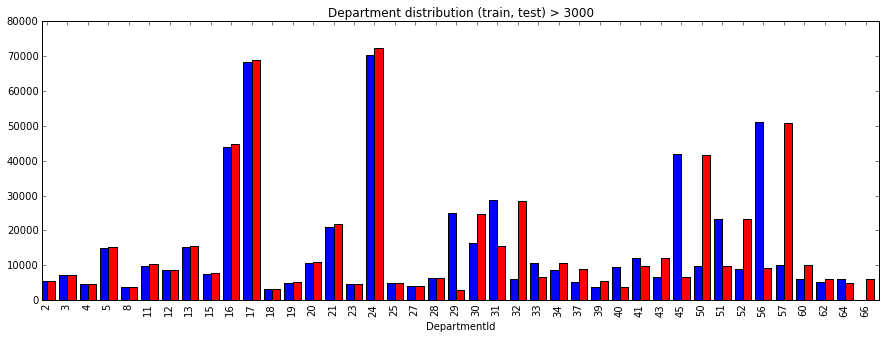

In [18]:
lst = train.groupby("DepartmentId")["DepartmentId"].count()
h = lst[lst > 3000].plot(kind = "bar", figsize=(15, 5), title="Department distribution (train, test) > 3000", 
             position=1, color="blue", width=0.4)
lst = test.groupby("DepartmentId")["DepartmentId"].count()
h = lst[lst > 3000].plot(kind = "bar", color="red", position=0, width=0.4)

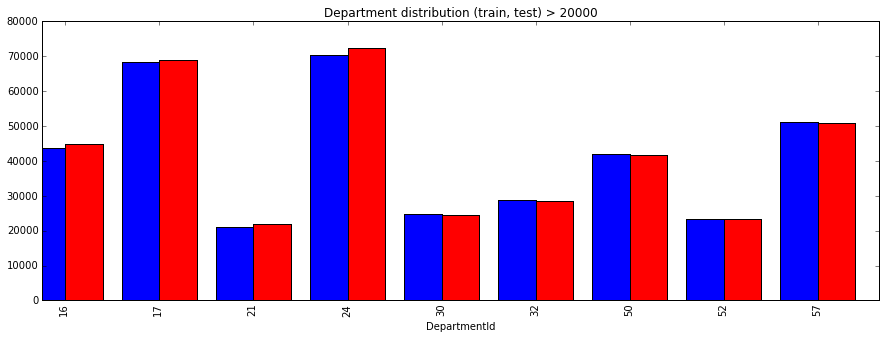

In [19]:
lst = train.groupby("DepartmentId")["DepartmentId"].count()
h = lst[lst > 20000].plot(kind = "bar", figsize=(15, 5), title="Department distribution (train, test) > 20000", 
             position=1, color="blue", width=0.4)
lst = test.groupby("DepartmentId")["DepartmentId"].count()
h = lst[lst > 20000].plot(kind = "bar", color="red", position=0, width=0.4)

In [20]:
print "Departments list"
for x in np.unique(train.sort(columns=["DepartmentId"]).DepartmentDescription):
    print x

Departments list
1-HR PHOTO (0)
ACCESSORIES (1)
AUTOMOTIVE (2)
BAKERY (3)
BATH AND SHOWER (4)
BEAUTY (5)
BEDDING (6)
BOOKS AND MAGAZINES (7)
BOYS WEAR (8)
BRAS & SHAPEWEAR (9)
CAMERAS AND SUPPLIES (10)
CANDY, TOBACCO, COOKIES (11)
CELEBRATION (12)
COMM BREAD (13)
CONCEPT STORES (14)
COOK AND DINE (15)
DAIRY (16)
DSD GROCERY (17)
ELECTRONICS (18)
FABRICS AND CRAFTS (19)
FINANCIAL SERVICES (20)
FROZEN FOODS (21)
FURNITURE (22)
GIRLS WEAR, 4-6X  AND 7-14 (23)
GROCERY DRY GOODS (24)
HARDWARE (25)
HEALTH AND BEAUTY AIDS (26)
HOME DECOR (27)
HOME MANAGEMENT (28)
HORTICULTURE AND ACCESS (29)
HOUSEHOLD CHEMICALS/SUPP (30)
HOUSEHOLD PAPER GOODS (31)
IMPULSE MERCHANDISE (32)
INFANT APPAREL (33)
INFANT CONSUMABLE HARDLINES (34)
JEWELRY AND SUNGLASSES (35)
LADIES SOCKS (36)
LADIESWEAR (37)
LARGE HOUSEHOLD GOODS (38)
LAWN AND GARDEN (39)
LIQUOR,WINE,BEER (40)
MEAT - FRESH & FROZEN (41)
MEDIA AND GAMING (42)
MENS WEAR (43)
MENSWEAR (44)
OFFICE SUPPLIES (45)
OPTICAL - FRAMES (46)
OPTICAL - LENSES (47

In [21]:
print "Number of observations for nan department in train set (68): " + str(train[train.DepartmentId == 68].shape[0])
print "Number of observations for nan department in test set (68): " + str(test[test.DepartmentId == 68].shape[0])

Number of observations for nan department in train set (68): 1361
Number of observations for nan department in test set (68): 1328


In [22]:
print "Departments with more than 20000 observations"
lst = train.groupby("DepartmentDescription")["DepartmentDescription"].count()
print lst[lst > 20000]
print ""
print "Departments with more than 10000 observations"
lst = train.groupby("DepartmentDescription")["DepartmentDescription"].count()
print lst[lst > 10000]

Departments with more than 20000 observations
DepartmentDescription
DAIRY (16)                       43820
DSD GROCERY (17)                 68332
FROZEN FOODS (21)                21101
GROCERY DRY GOODS (24)           70402
HOUSEHOLD CHEMICALS/SUPP (30)    24880
IMPULSE MERCHANDISE (32)         28712
PERSONAL CARE (50)               41969
PHARMACY OTC (52)                23306
PRODUCE (57)                     51115
Name: DepartmentDescription, dtype: int64

Departments with more than 10000 observations
DepartmentDescription
BEAUTY (5)                          14865
COMM BREAD (13)                     15244
DAIRY (16)                          43820
DSD GROCERY (17)                    68332
FINANCIAL SERVICES (20)             10723
FROZEN FOODS (21)                   21101
GROCERY DRY GOODS (24)              70402
HOUSEHOLD CHEMICALS/SUPP (30)       24880
HOUSEHOLD PAPER GOODS (31)          16274
IMPULSE MERCHANDISE (32)            28712
INFANT CONSUMABLE HARDLINES (34)    10646
MENS WEA

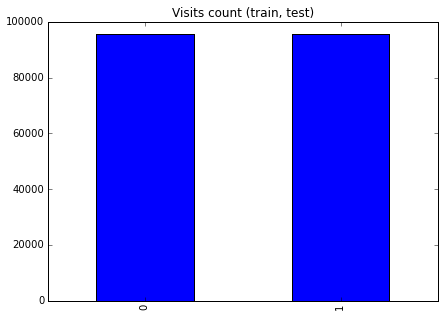

In [23]:
h = pd.Series([len(train.VisitNumber.unique()), len(test.VisitNumber.unique())]).plot(
    kind = "bar", figsize=(7, 5), title="Visits count (train, test)")

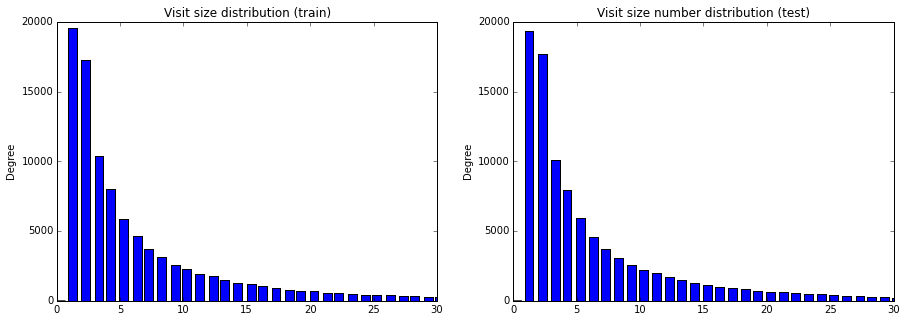

In [24]:
fig, axs = plt.subplots(1,2)
lst = pd.Series(train.VisitNumber.value_counts().values)
h = lst.plot(kind = "hist", bins=200, figsize=(15, 5), title="Visit size distribution (train)", 
             ax=axs[0], range=[0, 30], width=0.7)
lst = pd.Series(test.VisitNumber.value_counts().values)
h = lst.plot(kind = "hist", range=[0, 30], bins=200, ax=axs[1], width=0.7, 
             title="Visit size number distribution (test)")

In [25]:
print "Number of different TripType in train data: " + str(len(train.TripType.unique()))

Number of different TripType in train data: 38


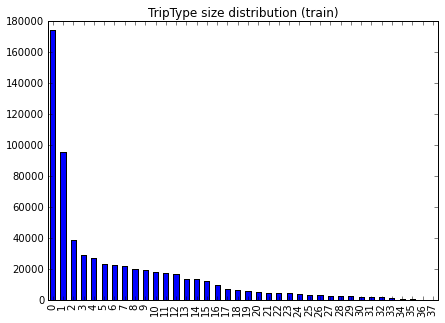

In [26]:
lst = pd.Series(train.TripType.value_counts().values)
h = lst.plot(kind = "bar", figsize=(7, 5), title="TripType size distribution (train)")

In [27]:
print train.TripType.value_counts()

40     174164
39      95504
37      38954
38      29565
25      27609
7       23199
8       22844
36      21990
44      20424
42      19468
24      18015
999     17590
9       16820
32      13843
5       13836
35      12501
33       9918
15       7147
3        6827
43       6383
41       5508
30       4861
34       4751
27       4613
21       4032
22       3592
6        3405
20       3116
18       2977
28       2664
26       2507
12       2108
29       2105
31       1765
19       1188
4         901
23        325
14         35
dtype: int64


In [28]:
train[train.TripType == "40"].head(20)

,TripType,VisitNumber,Upc,ScanCount,DepartmentDescription,FinelineNumber,Weekday,DepartmentId,UpcId
222,40,98,7874201706 (86475),1,DSD GROCERY (17),3562,5,17,86475
223,40,98,3400001314 (21604),1,"CANDY, TOBACCO, COOKIES (11)",78,5,11,21604
224,40,98,7874200645 (86281),1,DSD GROCERY (17),4672,5,17,86281
225,40,98,60538815805 (46698),2,SHOES (62),4815,5,62,46698
226,40,98,7431255366 (74604),1,PHARMACY OTC (52),502,5,52,74604
227,40,98,68113104849 (56359),1,BEAUTY (5),3907,5,5,56359
228,40,98,81655901251 (96369),1,PERSONAL CARE (50),3123,5,50,96369
229,40,98,7874209667 (87969),1,HOUSEHOLD PAPER GOODS (31),6010,5,31,87969
230,40,98,7874209664 (87966),1,HOUSEHOLD PAPER GOODS (31),6020,5,31,87966
231,40,98,4000048815 (28116),1,"CANDY, TOBACCO, COOKIES (11)",79,5,11,28116


In [29]:
train[train.TripType == "39"].head(20)

,TripType,VisitNumber,Upc,ScanCount,DepartmentDescription,FinelineNumber,Weekday,DepartmentId,UpcId
71,39,26,89470001034 (121866),2,DAIRY (16),1450,5,16,121866
72,39,26,84943400209 (103134),1,COOK AND DINE (15),2072,5,15,103134
73,39,26,3663200828 (23900),1,FROZEN FOODS (21),1850,5,21,23900
74,39,26,81829001273 (96930),3,DAIRY (16),1450,5,16,96930
75,39,26,89470001006 (121855),1,DAIRY (16),1450,5,16,121855
76,39,26,79108330121 (89662),1,PHARMACY OTC (52),535,5,52,89662
77,39,26,4011 (28227),1,PRODUCE (57),5501,5,57,28227
78,39,26,7874202251 (86604),1,FROZEN FOODS (21),2003,5,21,86604
79,39,26,4009450167 (28199),1,COOK AND DINE (15),579,5,15,28199
156,39,79,4000049570 (28130),1,"CANDY, TOBACCO, COOKIES (11)",224,5,11,28130


In [30]:
train[train.TripType == "37"].head(20)

,TripType,VisitNumber,Upc,ScanCount,DepartmentDescription,FinelineNumber,Weekday,DepartmentId,UpcId
178,37,86,7225001102 (68237),1,COMM BREAD (13),3761,5,13,68237
179,37,86,7464100146 (75451),1,PRODUCE (57),5930,5,57,75451
180,37,86,75166647006 (76648),2,PRODUCE (57),7841,5,57,76648
181,37,86,75166647006 (76648),1,PRODUCE (57),7841,5,57,76648
182,37,86,3000006403 (17522),1,GROCERY DRY GOODS (24),3555,5,24,17522
183,37,86,8680000522 (105398),1,BEAUTY (5),2105,5,5,105398
184,37,86,3338365301 (21250),1,PRODUCE (57),7602,5,57,21250
185,37,86,71722616151 (66322),1,PERSONAL CARE (50),5018,5,50,66322
186,37,86,7073405372 (61721),1,GROCERY DRY GOODS (24),3352,5,24,61721
187,37,86,4046 (28745),1,PRODUCE (57),5620,5,57,28745


In [31]:
train_nan_upc = train[train.UpcId == 124693]
print train_nan_upc.shape[0]

4129


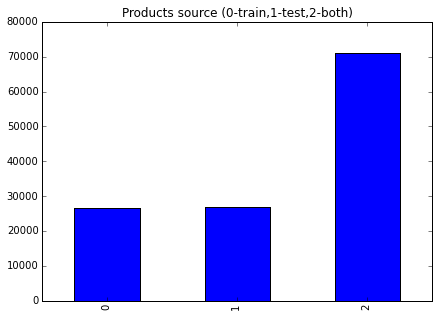

In [32]:
lst = [0, 0, 0]
for product in products.values():
    lst[product.source] += 1
h = pd.Series(lst).plot(kind = "bar", figsize=(7, 5), title="Products source (0-train,1-test,2-both)")

In [33]:
print "Number of different FinelineNumber in train data: " + str(len(train.FinelineNumber.unique()))
print "Number of different FinelineNumber in test data: " + str(len(train.FinelineNumber.unique()))

Number of different FinelineNumber in train data: 5196
Number of different FinelineNumber in test data: 5196


#### Prediction

In [34]:
# Some tricks to load xgboost on windows
def get_framework_path():
    return os.path.expandvars("%KaggleFrameworkPath%")

def attach_xgboost():
    sys.path.append(os.path.join(get_framework_path(), 'xgboost\\wrapper'))
    
attach_xgboost()
import xgboost as xgb

In [35]:
from sklearn import cross_validation
import csv

In [36]:
def score(yhat, y):
    print yhat[0]
    print y[0]

In [37]:
data_train = pd.read_csv("data/data_train.csv")
data_train.TripType = data_train.TripType.astype(str)
le = LabelEncoder()
le.fit(data_train.TripType)
data_train["TripTypeId"] = 0
data_train.TripTypeId = le.transform(data_train.TripType)

data_test = pd.read_csv("data/data_test.csv")

In [38]:
data_train.head(10)

,VisitNumber,Weekday,NumberOfProducts,NumberOfDepartments,NumberOfFinelines,ProductsSum,TripType,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,Department_7,Department_8,Department_9,Department_10,Department_11,Department_12,Department_13,Department_14,Department_15,Department_16,Department_17,Department_18,Department_19,Department_20,Department_21,Department_22,Department_23,Department_24,Department_25,Department_26,Department_27,Department_28,Department_29,Department_30,Department_31,Department_32,Department_33,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41,Department_42,Department_43,Department_44,Department_45,Department_46,Department_47,Department_48,Department_49,Department_50,Department_51,Department_52,Department_53,Department_54,Department_55,Department_56,Department_57,Department_58,Department_59,Department_60,Department_61,Department_62,Department_63,Department_64,Department_65,Department_66,Department_67,Department_68,FinelineNumber_0,FinelineNumber_1,FinelineNumber_2,FinelineNumber_3,FinelineNumber_4,FinelineNumber_5,FinelineNumber_6,FinelineNumber_7,FinelineNumber_8,FinelineNumber_9,FinelineNumber_10,FinelineNumber_11,FinelineNumber_12,FinelineNumber_13,FinelineNumber_14,FinelineNumber_15,FinelineNumber_16,FinelineNumber_17,FinelineNumber_18,FinelineNumber_19,FinelineNumber_20,FinelineNumber_21,FinelineNumber_22,FinelineNumber_23,FinelineNumber_24,FinelineNumber_25,FinelineNumber_26,FinelineNumber_27,FinelineNumber_28,FinelineNumber_29,FinelineNumber_30,FinelineNumber_31,FinelineNumber_32,FinelineNumber_33,FinelineNumber_34,FinelineNumber_35,FinelineNumber_36,FinelineNumber_37,FinelineNumber_38,FinelineNumber_39,FinelineNumber_40,FinelineNumber_41,FinelineNumber_42,FinelineNumber_43,FinelineNumber_44,FinelineNumber_45,FinelineNumber_46,FinelineNumber_47,FinelineNumber_48,FinelineNumber_49,FinelineNumber_50,FinelineNumber_51,FinelineNumber_52,FinelineNumber_53,FinelineNumber_54,FinelineNumber_55,FinelineNumber_56,FinelineNumber_57,FinelineNumber_58,FinelineNumber_59,FinelineNumber_60,FinelineNumber_61,FinelineNumber_62,FinelineNumber_63,FinelineNumber_64,FinelineNumber_65,FinelineNumber_66,FinelineNumber_67,FinelineNumber_68,FinelineNumber_69,FinelineNumber_70,FinelineNumber_71,FinelineNumber_72,FinelineNumber_73,FinelineNumber_74,FinelineNumber_75,FinelineNumber_76,FinelineNumber_77,FinelineNumber_78,FinelineNumber_79,FinelineNumber_80,FinelineNumber_81,FinelineNumber_82,FinelineNumber_83,FinelineNumber_84,FinelineNumber_85,FinelineNumber_86,FinelineNumber_87,FinelineNumber_88,FinelineNumber_89,FinelineNumber_90,FinelineNumber_91,FinelineNumber_92,FinelineNumber_93,FinelineNumber_94,FinelineNumber_95,FinelineNumber_96,FinelineNumber_97,FinelineNumber_98,FinelineNumber_99,FinelineNumber_100,FinelineNumber_101,FinelineNumber_102,FinelineNumber_103,FinelineNumber_104,FinelineNumber_105,FinelineNumber_106,FinelineNumber_107,FinelineNumber_108,FinelineNumber_109,FinelineNumber_110,FinelineNumber_111,FinelineNumber_112,FinelineNumber_113,FinelineNumber_114,FinelineNumber_115,FinelineNumber_116,FinelineNumber_117,FinelineNumber_118,FinelineNumber_119,FinelineNumber_120,FinelineNumber_121,FinelineNumber_122,FinelineNumber_123,FinelineNumber_124,FinelineNumber_125,FinelineNumber_126,FinelineNumber_127,FinelineNumber_128,FinelineNumber_129,FinelineNumber_130,FinelineNumber_131,FinelineNumber_132,FinelineNumber_133,FinelineNumber_134,FinelineNumber_135,FinelineNumber_136,FinelineNumber_137,FinelineNumber_138,FinelineNumber_139,FinelineNumber_140,FinelineNumber_141,FinelineNumber_142,FinelineNumber_143,FinelineNumber_144,FinelineNumber_145,FinelineNumber_146,FinelineNumber_147,FinelineNumber_148,FinelineNumber_149,FinelineNumber_150,FinelineNumber_151,FinelineNumber_152,FinelineNumber_153,FinelineNumber_154,FinelineNumber_155,FinelineNumber_156,FinelineNumber_157,FinelineNumber_158,FinelineNumber_159,FinelineNumber_16

In [39]:
seed = 2
params = {"objective": "multi:softprob",
          #"objective": "multi:softmax",
          "num_class": 38,
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": seed
         }
features = ["Weekday","NumberOfProducts","NumberOfDepartments","NumberOfFinelines","ProductsSum"] 
for department_id in departments:
    features.append("Department_" + str(department_id))
for number in xrange(n_hash):
    features.append("FinelineNumber_" + str(number))
X_train, X_test = cross_validation.train_test_split(data_train, test_size=0.05)
num_rounds = 300
dtrain = xgb.DMatrix(X_train[features], label=X_train["TripTypeId"])
dvalid = xgb.DMatrix(X_test[features], label=X_test["TripTypeId"])
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=50, 
                verbose_eval=True)

Will train until train error hasn't decreased in 50 rounds.
[0]	eval-merror:0.455686	train-merror:0.434855
[1]	eval-merror:0.349916	train-merror:0.338409
[2]	eval-merror:0.329850	train-merror:0.316657
[3]	eval-merror:0.311664	train-merror:0.293619
[4]	eval-merror:0.309156	train-merror:0.287457
[5]	eval-merror:0.304139	train-merror:0.278501
[6]	eval-merror:0.300794	train-merror:0.272417
[7]	eval-merror:0.299122	train-merror:0.267950
[8]	eval-merror:0.296823	train-merror:0.263120
[9]	eval-merror:0.293896	train-merror:0.259192
[10]	eval-merror:0.289925	train-merror:0.254417
[11]	eval-merror:0.288880	train-merror:0.251392
[12]	eval-merror:0.286162	train-merror:0.248817
[13]	eval-merror:0.284908	train-merror:0.245770
[14]	eval-merror:0.283027	train-merror:0.243030
[15]	eval-merror:0.280936	train-merror:0.240687
[16]	eval-merror:0.281564	train-merror:0.237958
[17]	eval-merror:0.281564	train-merror:0.234668
[18]	eval-merror:0.281355	train-merror:0.232688
[19]	eval-merror:0.281355	train-merror

In [40]:
test_probs = gbm.predict(xgb.DMatrix(data_test[features]))

In [41]:
data_test.head(10)

,VisitNumber,Weekday,NumberOfProducts,NumberOfDepartments,NumberOfFinelines,ProductsSum,TripType,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,Department_7,Department_8,Department_9,Department_10,Department_11,Department_12,Department_13,Department_14,Department_15,Department_16,Department_17,Department_18,Department_19,Department_20,Department_21,Department_22,Department_23,Department_24,Department_25,Department_26,Department_27,Department_28,Department_29,Department_30,Department_31,Department_32,Department_33,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41,Department_42,Department_43,Department_44,Department_45,Department_46,Department_47,Department_48,Department_49,Department_50,Department_51,Department_52,Department_53,Department_54,Department_55,Department_56,Department_57,Department_58,Department_59,Department_60,Department_61,Department_62,Department_63,Department_64,Department_65,Department_66,Department_67,Department_68,FinelineNumber_0,FinelineNumber_1,FinelineNumber_2,FinelineNumber_3,FinelineNumber_4,FinelineNumber_5,FinelineNumber_6,FinelineNumber_7,FinelineNumber_8,FinelineNumber_9,FinelineNumber_10,FinelineNumber_11,FinelineNumber_12,FinelineNumber_13,FinelineNumber_14,FinelineNumber_15,FinelineNumber_16,FinelineNumber_17,FinelineNumber_18,FinelineNumber_19,FinelineNumber_20,FinelineNumber_21,FinelineNumber_22,FinelineNumber_23,FinelineNumber_24,FinelineNumber_25,FinelineNumber_26,FinelineNumber_27,FinelineNumber_28,FinelineNumber_29,FinelineNumber_30,FinelineNumber_31,FinelineNumber_32,FinelineNumber_33,FinelineNumber_34,FinelineNumber_35,FinelineNumber_36,FinelineNumber_37,FinelineNumber_38,FinelineNumber_39,FinelineNumber_40,FinelineNumber_41,FinelineNumber_42,FinelineNumber_43,FinelineNumber_44,FinelineNumber_45,FinelineNumber_46,FinelineNumber_47,FinelineNumber_48,FinelineNumber_49,FinelineNumber_50,FinelineNumber_51,FinelineNumber_52,FinelineNumber_53,FinelineNumber_54,FinelineNumber_55,FinelineNumber_56,FinelineNumber_57,FinelineNumber_58,FinelineNumber_59,FinelineNumber_60,FinelineNumber_61,FinelineNumber_62,FinelineNumber_63,FinelineNumber_64,FinelineNumber_65,FinelineNumber_66,FinelineNumber_67,FinelineNumber_68,FinelineNumber_69,FinelineNumber_70,FinelineNumber_71,FinelineNumber_72,FinelineNumber_73,FinelineNumber_74,FinelineNumber_75,FinelineNumber_76,FinelineNumber_77,FinelineNumber_78,FinelineNumber_79,FinelineNumber_80,FinelineNumber_81,FinelineNumber_82,FinelineNumber_83,FinelineNumber_84,FinelineNumber_85,FinelineNumber_86,FinelineNumber_87,FinelineNumber_88,FinelineNumber_89,FinelineNumber_90,FinelineNumber_91,FinelineNumber_92,FinelineNumber_93,FinelineNumber_94,FinelineNumber_95,FinelineNumber_96,FinelineNumber_97,FinelineNumber_98,FinelineNumber_99,FinelineNumber_100,FinelineNumber_101,FinelineNumber_102,FinelineNumber_103,FinelineNumber_104,FinelineNumber_105,FinelineNumber_106,FinelineNumber_107,FinelineNumber_108,FinelineNumber_109,FinelineNumber_110,FinelineNumber_111,FinelineNumber_112,FinelineNumber_113,FinelineNumber_114,FinelineNumber_115,FinelineNumber_116,FinelineNumber_117,FinelineNumber_118,FinelineNumber_119,FinelineNumber_120,FinelineNumber_121,FinelineNumber_122,FinelineNumber_123,FinelineNumber_124,FinelineNumber_125,FinelineNumber_126,FinelineNumber_127,FinelineNumber_128,FinelineNumber_129,FinelineNumber_130,FinelineNumber_131,FinelineNumber_132,FinelineNumber_133,FinelineNumber_134,FinelineNumber_135,FinelineNumber_136,FinelineNumber_137,FinelineNumber_138,FinelineNumber_139,FinelineNumber_140,FinelineNumber_141,FinelineNumber_142,FinelineNumber_143,FinelineNumber_144,FinelineNumber_145,FinelineNumber_146,FinelineNumber_147,FinelineNumber_148,FinelineNumber_149,FinelineNumber_150,FinelineNumber_151,FinelineNumber_152,FinelineNumber_153,FinelineNumber_154,FinelineNumber_155,FinelineNumber_156,FinelineNumber_157,FinelineNumber_158,FinelineNumber_159,FinelineNumber_16

In [42]:
submission = pd.DataFrame(index=range(data_test.shape[0]))
names = map(lambda x: "TripType_" + x, ['12', '14', '15', '18', '19', '20', '21', '22', '23',
                                        '24', '25', '26', '27', '28', '29', '3', '30', '31',
                                        '32', '33', '34', '35', '36', '37', '38', '39', '4',
                                        '40', '41', '42', '43', '44', '5', '6', '7', '8', '9',
                                        '999'])
submission["VisitNumber"] = data_test.VisitNumber
ordered_names = map(lambda x: "TripType_" + x, ['3', '4', '5', '6', '7', '8', '9', '12', '14', 
                                                '15', '18', '19', '20', '21', '22', '23', '24', 
                                                '25', '26', '27', '28', '29', '30', '31', '32', 
                                                '33', '34', '35', '36', '37', '38', '39', '40', 
                                                '41', '42', '43', '44', '999'])
for name in ordered_names:
    submission[name] = 0.0
j = 0
for i, row in data_test.iterrows():
    for k in xrange(len(test_probs[0])):
        prob = test_probs[j][k]
        #prob = math.ceil(prob*100000)/100000
        submission.set_value(i, names[k], prob)
    j += 1
submission.head(10)
submission.to_csv("submission.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)